<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [199]:
# Set your student number
student_number = 400101956
Name = 'Mohammad'
Last_Name = 'Morsali'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [200]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch.optim as optim
import random


In [201]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [202]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

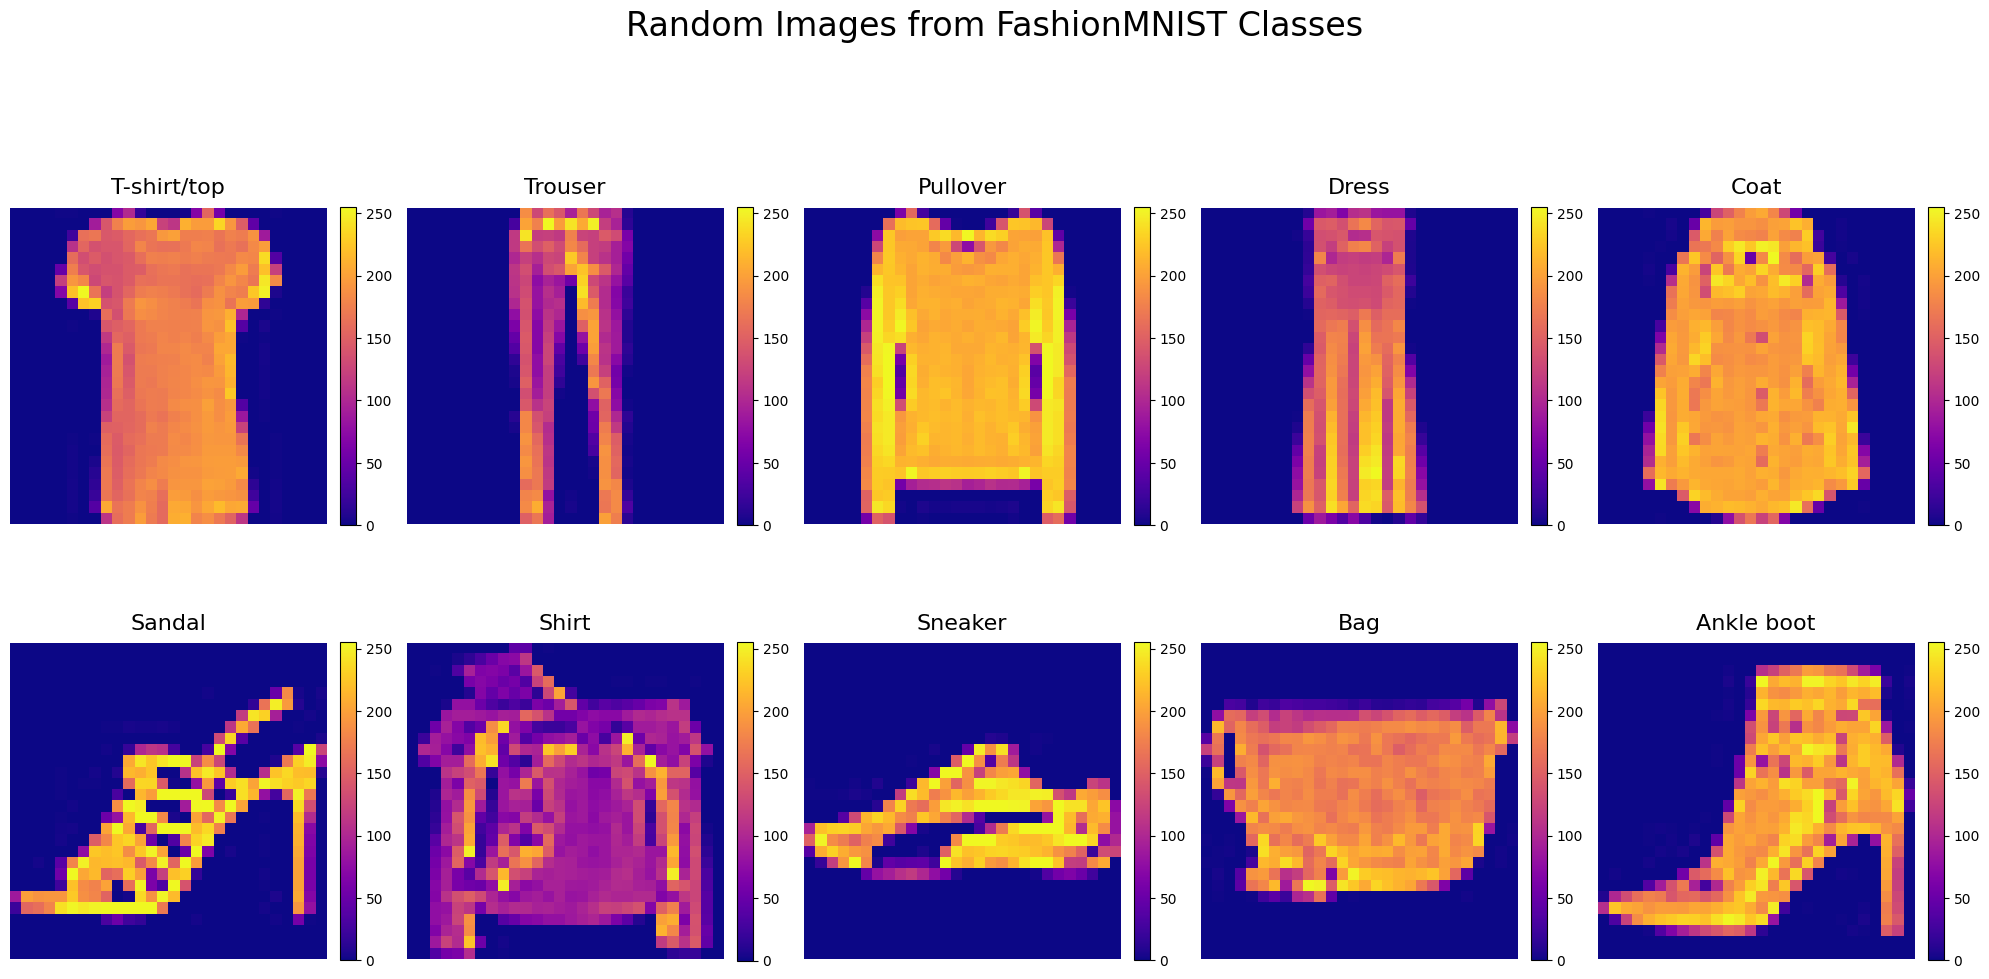

In [203]:

# Define class names
clothing_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Create a figure and axes with a larger size for better visibility
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Set a super title for the figure
fig.suptitle("Random Images from FashionMNIST Classes", fontsize=24, y=1.05)

# Loop over each class
for idx, class_name in enumerate(clothing_classes):
    # Filter the dataset for the current class
    class_specific_data = dataset.data[dataset.targets == idx]
    
    # Select a random image from the class-specific data
    random_img = random.choice(class_specific_data)
    
    # Determine the position of the subplot
    row = idx // 5
    col = idx % 5
    
    # Plot the image with a colormap for better visibility
    im = axes[row, col].imshow(random_img, cmap=cm.plasma, interpolation='nearest')
    
    # Set the title of the subplot
    axes[row, col].set_title(class_name, fontsize=16, pad=10)
    
    # Remove the axis
    axes[row, col].axis("off")

    # Add a frame around the image for better distinction
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Add a colorbar to each subplot
    fig.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Sample data for testing
# Generate sample data for testing
sample_data = np.random.randint(0, 256, size=(1000, 28, 28), dtype=np.uint8)
sample_targets = np.random.randint(0, 10, size=(1000,), dtype=np.int64)

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset. 

In [204]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [205]:
######################
#   YOUR CODE HERE   #
######################
val_frac =0.2  ## Set the fraction for the validation set
rand_seed =400101956  ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

In [206]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [207]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 64 ## Set the batch size

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

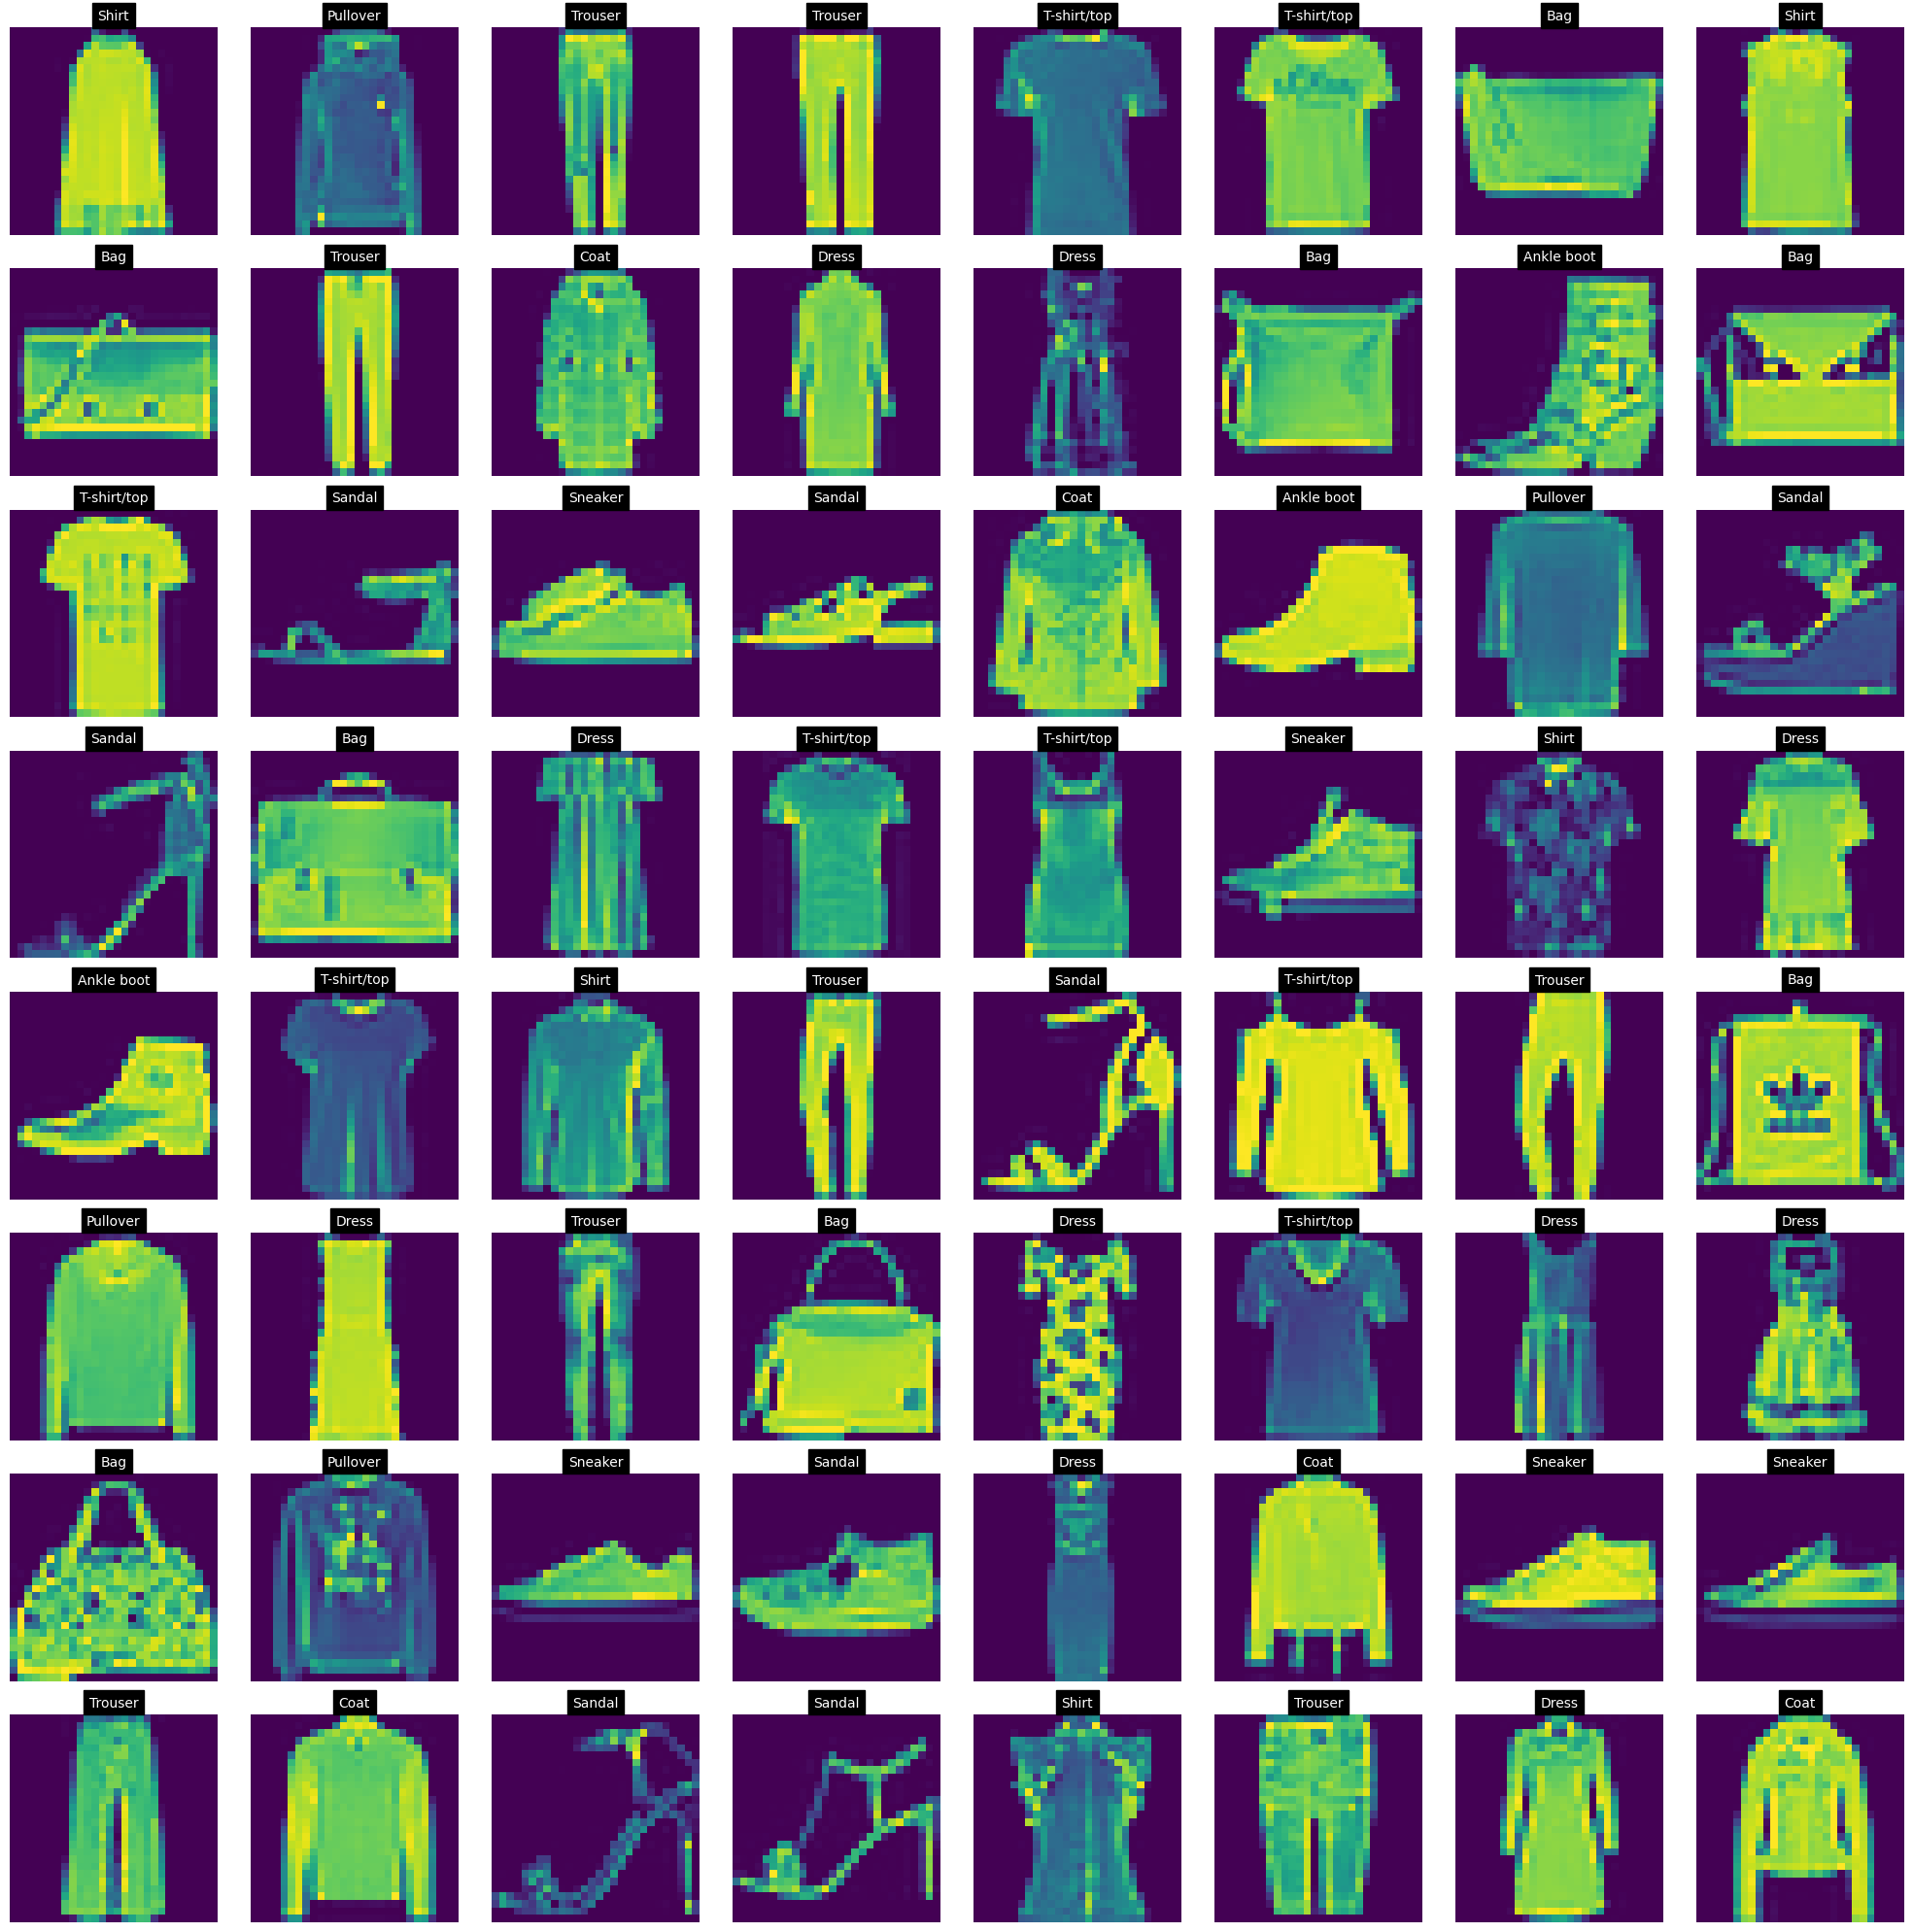

In [208]:
# Get the class names from the dataset
class_labels = train_dl.dataset.classes

# Create an iterator for the DataLoader
train_data_iter = iter(train_dl)

# Get the next batch of images and labels
images_batch, labels_batch = next(train_data_iter)

# Create a larger figure for better visibility
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))  # Adjusted to 8 rows and 8 columns

# Loop over each image in the batch
for idx, image in enumerate(images_batch):
    # Determine the position of the subplot
    row = idx // 8
    col = idx % 8
    
    # Reshape the image and plot it with a colormap for better visibility
    axes[row, col].imshow(image.reshape(28, 28), cmap='viridis')
    
    # Remove the axis
    axes[row, col].axis("off")

    # Add a frame around the image for better distinction
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    # Add a title to each subplot
    axes[row, col].set_title(class_labels[labels_batch[idx]], fontsize=10, color='white', backgroundcolor='black')

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [209]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [210]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1, num_classes=10):
        super(ImageClassifierNet, self).__init__()

        # Define the layers in a more compact way using nn.Sequential
        self.features = self._make_layers(n_channels)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(10 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _make_layers(self, n_channels):
        layers = []
        in_channels = n_channels
        for x in [10, 'M', 10]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, X):
        # Forward pass through the layers
        out = self.features(X)
        out = self.classifier(out)
        return out

In [211]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [212]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            18,496
├─MaxPool2d: 1-6                         [64, 64, 3, 3]            --
├─Linear: 1-7                            [64, 128]                 73,856
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 98,442
Trainable params: 98,442
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 129.05
Input size (MB): 0.20
Forward/backward pass size (MB): 11.31
Params size (MB): 0.39
Estimated Total Size (MB): 11.90

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [213]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

def calculate_loss(dataloader, model, loss_fn):
    running_loss = 0.0
    for data in dataloader:
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
    return running_loss / len(dataloader)

def train_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for data in dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(dataloader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        accuracy = sum(calculate_accuracy(model(inputs), labels) for inputs, labels in dataloader) / len(dataloader)
        loss = calculate_loss(dataloader, model, loss_fn)
    return accuracy, loss

def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    optimizer = opt_fn(model.parameters(), lr=lr)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(n_epochs):
        train_epoch(train_dl, model, loss_fn, optimizer)
        train_accuracy, train_loss = evaluate(train_dl, model, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if val_dl:
            val_accuracy, val_loss = evaluate(val_dl, model, loss_fn)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        else:
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [214]:
# Number of training epochs
num_epochs = 10


# Define the learning rate
lr = 0.001 

# Define the loss function
loss_fn = nn.CrossEntropyLoss() 

# Pass the optimizer class, not an instance of it
opt_fn = optim.Adam



In [215]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.3961, Train Accuracy: 85.36%, Val Loss: 0.4143, Val Accuracy: 84.54%
Epoch 2/10, Train Loss: 0.3055, Train Accuracy: 88.94%, Val Loss: 0.3349, Val Accuracy: 87.99%
Epoch 3/10, Train Loss: 0.2543, Train Accuracy: 90.67%, Val Loss: 0.2864, Val Accuracy: 89.30%
Epoch 4/10, Train Loss: 0.2304, Train Accuracy: 91.66%, Val Loss: 0.2768, Val Accuracy: 89.59%
Epoch 5/10, Train Loss: 0.2786, Train Accuracy: 89.62%, Val Loss: 0.3295, Val Accuracy: 88.21%
Epoch 6/10, Train Loss: 0.2114, Train Accuracy: 91.95%, Val Loss: 0.2660, Val Accuracy: 90.28%
Epoch 7/10, Train Loss: 0.1890, Train Accuracy: 92.85%, Val Loss: 0.2494, Val Accuracy: 90.69%
Epoch 8/10, Train Loss: 0.1624, Train Accuracy: 93.88%, Val Loss: 0.2533, Val Accuracy: 90.99%
Epoch 9/10, Train Loss: 0.1692, Train Accuracy: 93.72%, Val Loss: 0.2644, Val Accuracy: 90.76%
Epoch 10/10, Train Loss: 0.1465, Train Accuracy: 94.39%, Val Loss: 0.2531, Val Accuracy: 91.28%


### Plot loss and accuracy

In [216]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

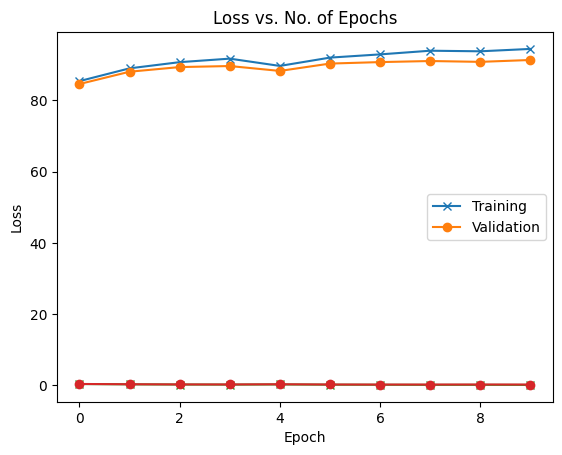

In [217]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [218]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [219]:
######################
#   YOUR CODE HERE   #
######################
num_epochs =10 # Max number of training epochs
lr = 0.001# Set the learning rate

In [220]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.1526, Train Accuracy: 94.40%
Epoch 2/10, Train Loss: 0.1346, Train Accuracy: 95.05%
Epoch 3/10, Train Loss: 0.1257, Train Accuracy: 95.32%
Epoch 4/10, Train Loss: 0.1093, Train Accuracy: 95.94%
Epoch 5/10, Train Loss: 0.1006, Train Accuracy: 96.33%
Epoch 6/10, Train Loss: 0.1022, Train Accuracy: 96.26%
Epoch 7/10, Train Loss: 0.0777, Train Accuracy: 97.21%
Epoch 8/10, Train Loss: 0.0890, Train Accuracy: 96.54%
Epoch 9/10, Train Loss: 0.0724, Train Accuracy: 97.35%
Epoch 10/10, Train Loss: 0.0707, Train Accuracy: 97.42%


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

C:\Users\user\AppData\Local\Temp\ipykernel_13716\2199563834.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")


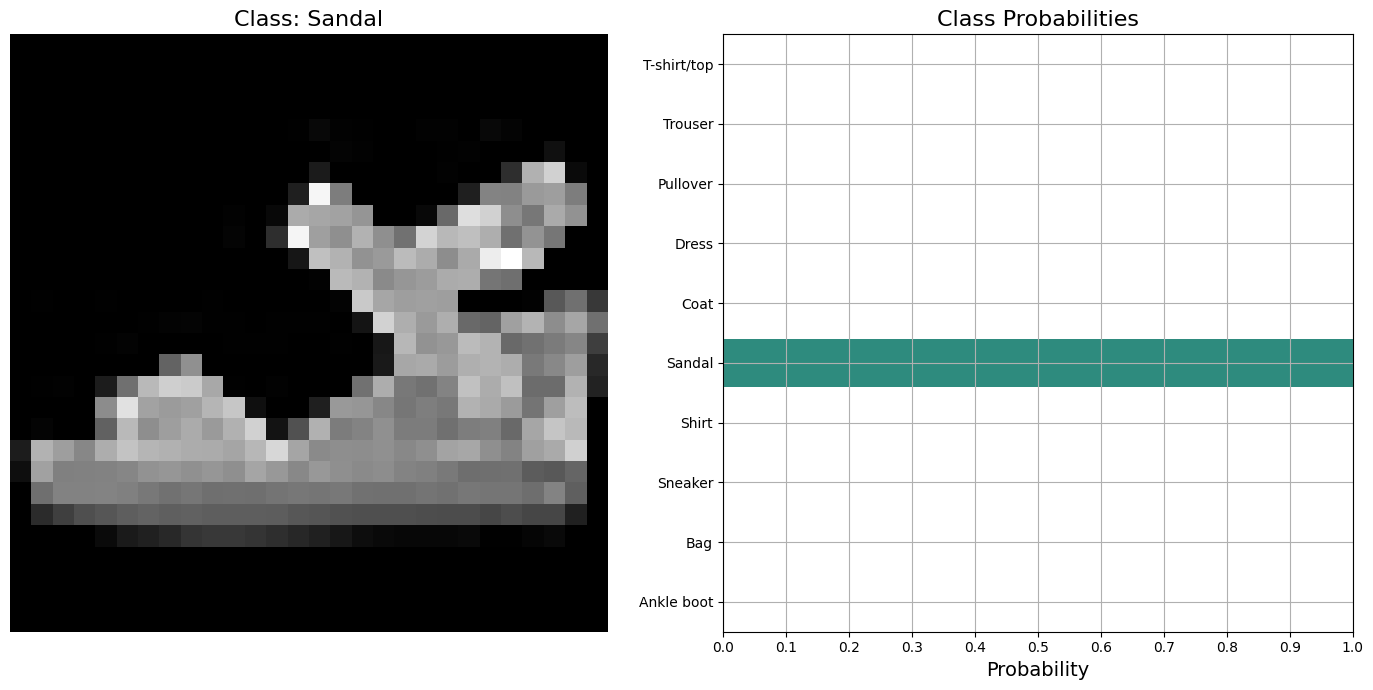

C:\Users\user\AppData\Local\Temp\ipykernel_13716\2199563834.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")


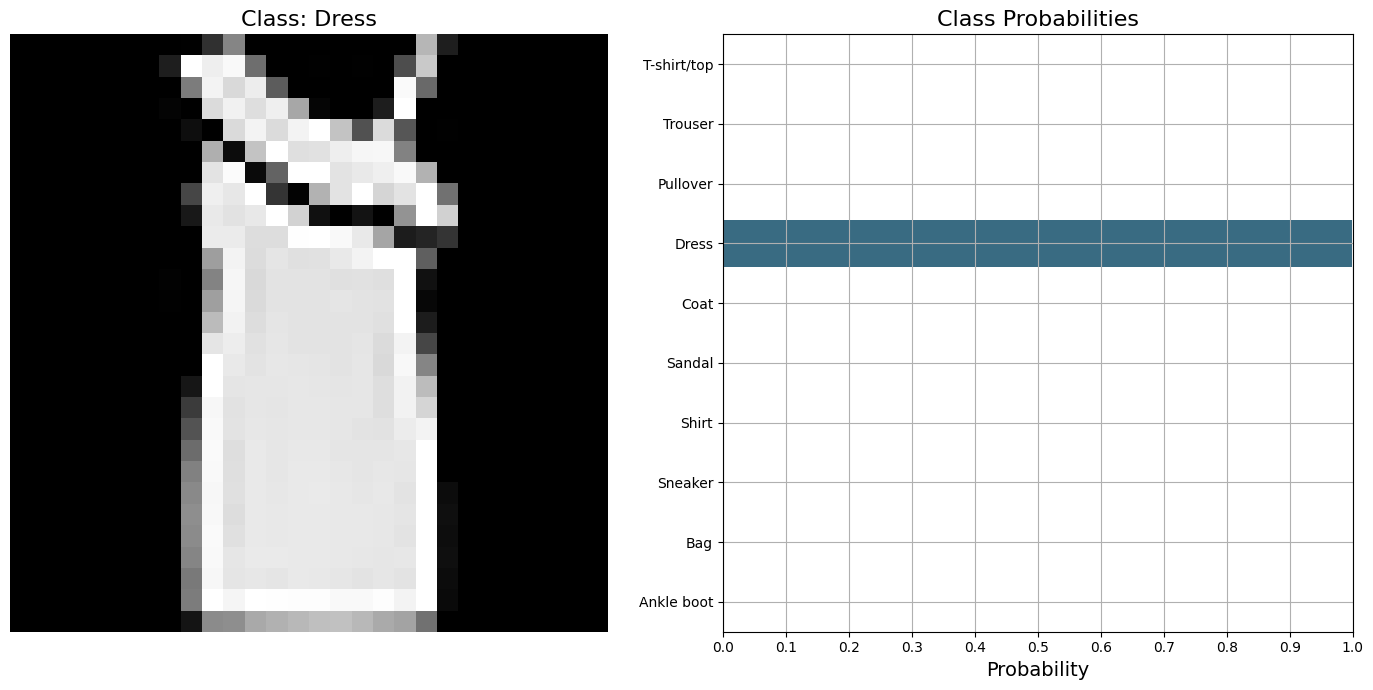

C:\Users\user\AppData\Local\Temp\ipykernel_13716\2199563834.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")


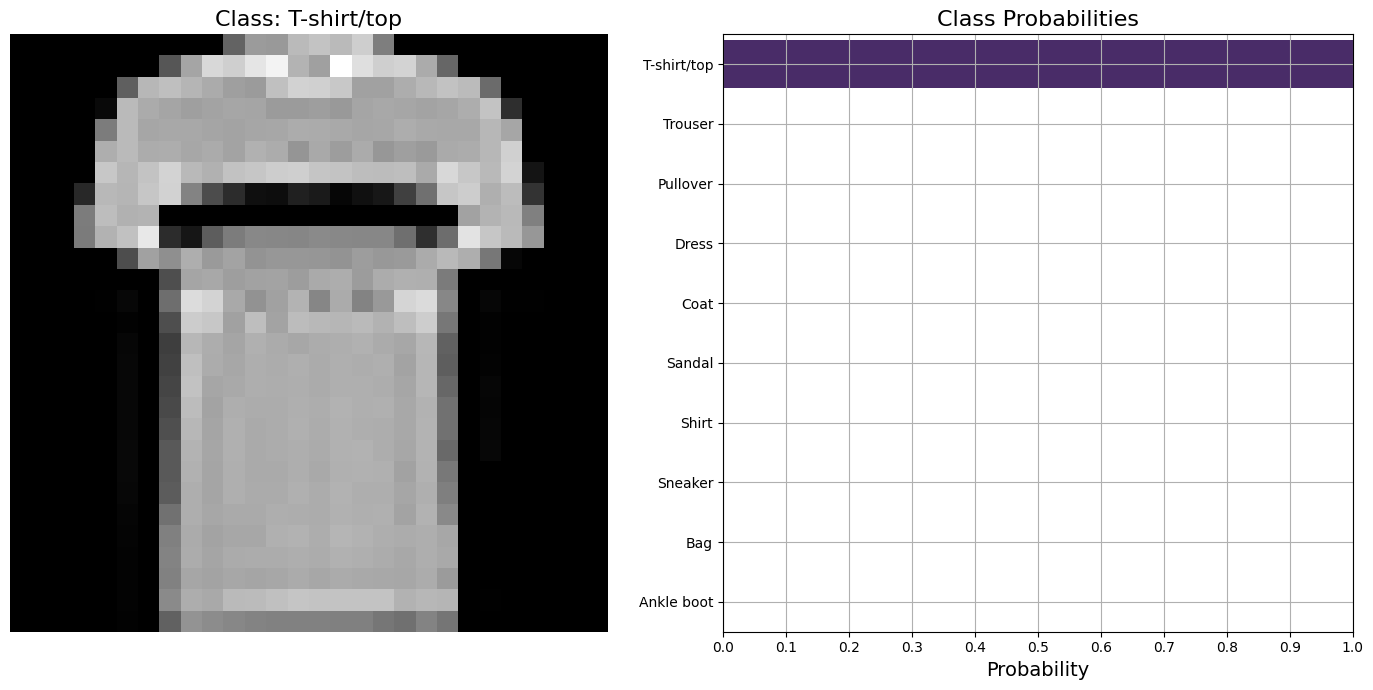

C:\Users\user\AppData\Local\Temp\ipykernel_13716\2199563834.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")


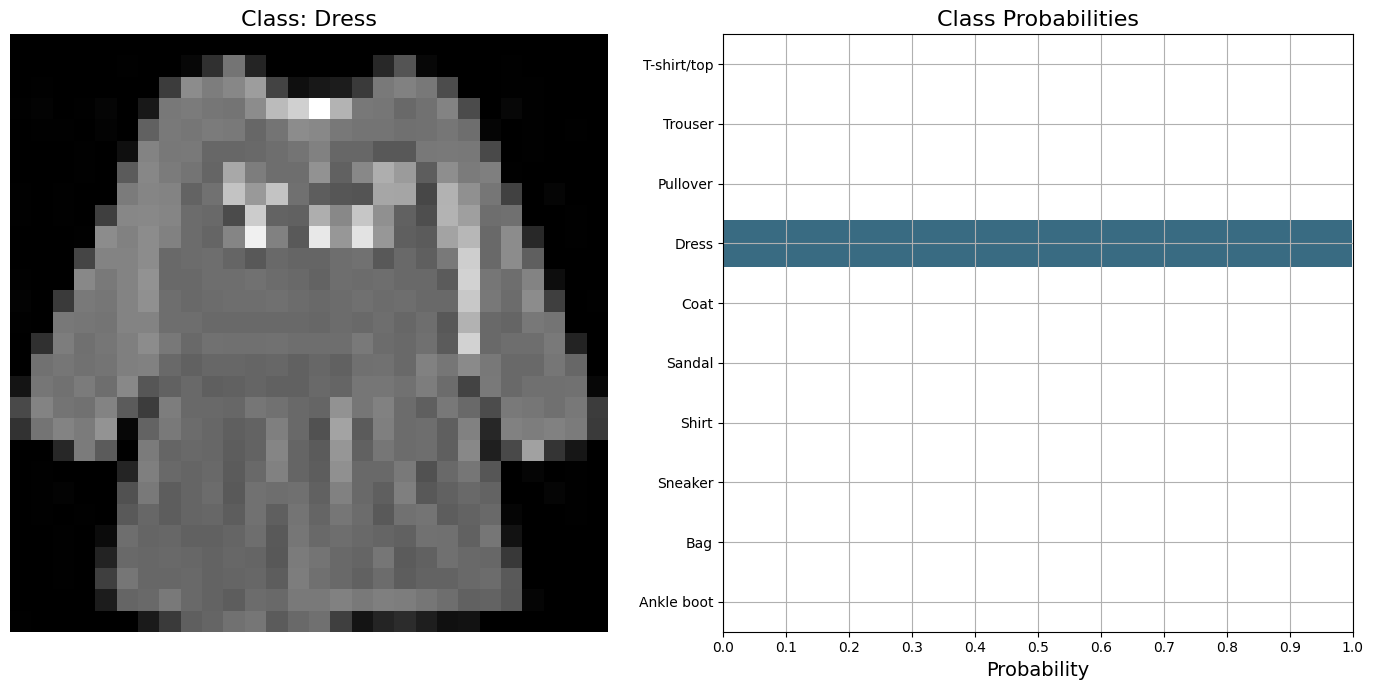

C:\Users\user\AppData\Local\Temp\ipykernel_13716\2199563834.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")


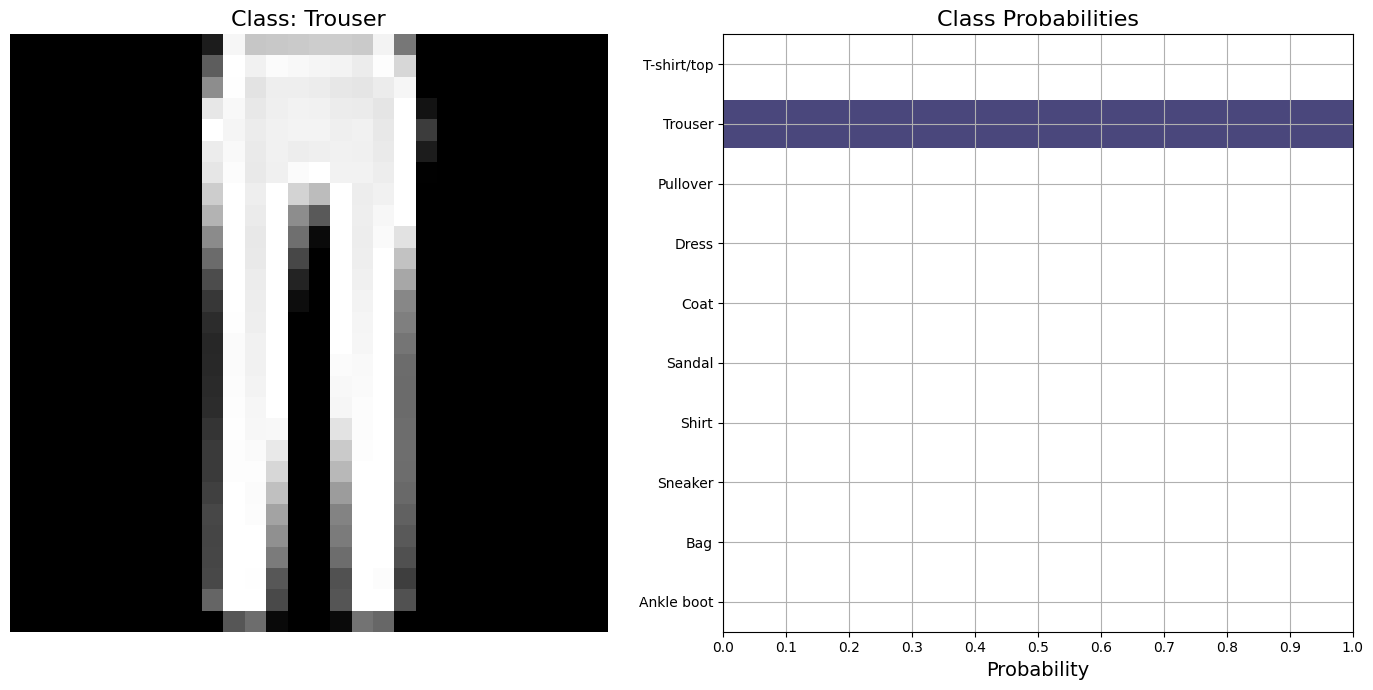

In [226]:
######################
#   YOUR CODE HERE   #
######################
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def display_prediction(img, lbl, probs, class_lbls):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    # Display the image
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title(f"Class: {class_lbls[lbl]}", fontsize=16)
    axs[0].axis('off')

    # Display the probabilities
    sns.barplot(x=probs, y=class_lbls, ax=axs[1], palette="viridis")
    axs[1].set_xlabel('Probability', fontsize=14)
    axs[1].set_title('Class Probabilities', fontsize=16)
    axs[1].set_xlim(0, 1)
    axs[1].xaxis.set_major_locator(MaxNLocator(nbins=11))
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Switch the model to evaluation mode
model.eval()

# Select random samples
random_samples = np.random.choice(indices, size=5, replace=False)

for sample in random_samples:
    img, lbl = dataset[sample]
    with torch.no_grad():
        result = model(img.unsqueeze(0))
        probs = torch.nn.functional.softmax(result, dim=1).squeeze().numpy()

    display_prediction(img.squeeze().numpy(), lbl, probs, dataset.classes)

### Save the model

In [222]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [223]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [224]:
def evaluate(model, data_loader):
    """
    Computes accuracy of the model on the provided data loader.

    Args:
        model: ImageClassifierNet object
        data_loader: DataLoader object

    Returns:
        Accuracy as a float value between 0 and 1.
    """
    model.eval()  # Switch the model to evaluation mode
    correct_preds_count = 0
    total_samples_count = 0

    with torch.no_grad():  # Disable gradient computation
        for data_batch, labels_batch in data_loader:
            output = model(data_batch)
            _, predicted_labels = torch.max(output.data, 1)
            total_samples_count += labels_batch.size(0)
            correct_preds_count += (predicted_labels == labels_batch).sum().item()

    accuracy = correct_preds_count / total_samples_count if total_samples_count > 0 else 0
    print(f'Accuracy of the network on the test images: {accuracy * 100}%')

    return accuracy

In [225]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Accuracy of the network on the test images: 91.25%
Test Accuracy = 0.9125
